# MNIST handwritten digits

Classifying handwritten digits using a neural network in pytorch.

Following the pytorch tutorials at https://pytorch.org/tutorials/beginner/basics/intro.html.

## Getting the data

In [1]:
# Packages and modules
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Functions and classes
from torchvision.transforms import ToTensor, Lambda
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [2]:
# Download and/or load dataset (thanks Yann), and transform to tensors, and one-hot encodings
target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
train = MNIST(root="data", transform=ToTensor(), target_transform=target_transform, download=True)
test = MNIST(root="data", transform=ToTensor(), target_transform=target_transform, download=True)

# Make dataloaders
train_dataloader = DataLoader(train, batch_size=64)
test_dataloader = DataLoader(test, batch_size=64)

# Enumerate training dataloader
examples = enumerate(train_dataloader)

# Get first batch of samples and check shape
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 10])


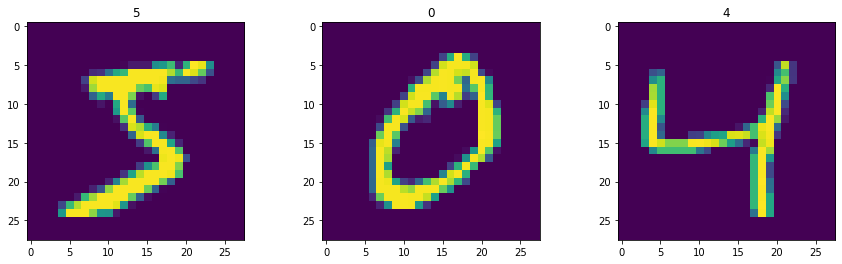

In [3]:
# Show first few inputs and labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
for i in range(3):
    ax = [ax1, ax2, ax3][i]
    ax.imshow(example_data[i][0])
    ax.set_title(f"{example_targets[i].argmax(0)}")
plt.show()

## Build neural network model

In [4]:
# Breakdown modelling functions
X = torch.rand(1, 28, 28)
print(f"Input: {X.shape}")
X_flat = nn.Flatten()(X)
print(f"Flattened: {X_flat.shape}")
X_l = nn.Linear(28*28, 4)(X_flat)
print(f"Linear: {X_l}")
X_r = nn.ReLU()(X_l)
print(f"ReLU: {X_r}")
logits = nn.Linear(4, 4)(X_r)
print(f"Model: {logits}")
pred_probab = nn.Softmax(dim=1)(logits)
print(f"Probabilities: {pred_probab}")
print(f"Predicted class: {pred_probab.argmax(1)}")

Input: torch.Size([1, 28, 28])
Flattened: torch.Size([1, 784])
Linear: tensor([[ 0.2939,  0.3932, -0.2364,  0.3076]], grad_fn=<AddmmBackward0>)
ReLU: tensor([[0.2939, 0.3932, 0.0000, 0.3076]], grad_fn=<ReluBackward0>)
Model: tensor([[-0.2723,  0.7258, -0.1613, -0.3001]], grad_fn=<AddmmBackward0>)
Probabilities: tensor([[0.1723, 0.4675, 0.1925, 0.1676]], grad_fn=<SoftmaxBackward0>)
Predicted class: tensor([1])


In [5]:
# Create a neural network
seq_modules = nn.Sequential(
    nn.Linear(28*28, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 10),
)
seq_modules(X_flat)

tensor([[ 0.0295, -0.0743,  0.0106, -0.0335, -0.0694, -0.0436, -0.0259, -0.0419,
          0.0284, -0.0412]], grad_fn=<AddmmBackward0>)

In [6]:
# Create neural network model class
class NeuralNetwork(nn.Module):
    def __init__(self, seq_modules):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = seq_modules

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
# Create neural network model
model = NeuralNetwork(seq_modules)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [8]:
name, param = next(model.named_parameters())
print(f"Layer: {name}")
print(f"Size: {param.size()}")
print(f"Values : {param[:2]} \n")

Layer: linear_relu_stack.0.weight
Size: torch.Size([512, 784])
Values : tensor([[-0.0065,  0.0070,  0.0206,  ..., -0.0197, -0.0236, -0.0235],
        [ 0.0246,  0.0034,  0.0152,  ..., -0.0008, -0.0063, -0.0210]],
       grad_fn=<SliceBackward0>) 



In [9]:
# Use model to get predictions
model(X)

tensor([[ 0.0295, -0.0743,  0.0106, -0.0335, -0.0694, -0.0436, -0.0259, -0.0419,
          0.0284, -0.0412]], grad_fn=<AddmmBackward0>)

## Move model to GPU

In [10]:
# Set device to GPU or CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [11]:
# Create neural network model
model = model.to(device)

In [12]:
# Use model to get predictions on GPU
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
print(f"Model: {logits}")

Model: tensor([[-0.0179, -0.1040, -0.0281, -0.0458, -0.0220, -0.0795, -0.0320,  0.0288,
          0.0463, -0.0481]], device='cuda:0', grad_fn=<AddmmBackward0>)


## Define training/validation functions

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            y = y.to(device)
            pred = model(X.to(device))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return correct

## Train model

In [14]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
last_correct = 0
for t in range(10):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    correct = test_loop(test_dataloader, model, loss_fn)
    if correct - last_correct < 0.01:
        break
    else:
        last_correct = correct
print("Done!")

Epoch 1
-------------------------------
loss: 2.295969  [    0/60000]
loss: 2.296462  [ 6400/60000]
loss: 2.293902  [12800/60000]
loss: 2.274433  [19200/60000]
loss: 2.280529  [25600/60000]
loss: 2.279639  [32000/60000]
loss: 2.268286  [38400/60000]
loss: 2.272213  [44800/60000]
loss: 2.255246  [51200/60000]
loss: 2.248823  [57600/60000]
Test Error: 
 Accuracy: 41.6%, Avg loss: 2.252288 

Epoch 2
-------------------------------
loss: 2.246755  [    0/60000]
loss: 2.244427  [ 6400/60000]
loss: 2.252091  [12800/60000]
loss: 2.208787  [19200/60000]
loss: 2.228142  [25600/60000]
loss: 2.229072  [32000/60000]
loss: 2.207558  [38400/60000]
loss: 2.225825  [44800/60000]
loss: 2.188483  [51200/60000]
loss: 2.180459  [57600/60000]
Test Error: 
 Accuracy: 55.9%, Avg loss: 2.184579 

Epoch 3
-------------------------------
loss: 2.175872  [    0/60000]
loss: 2.168421  [ 6400/60000]
loss: 2.189564  [12800/60000]
loss: 2.107490  [19200/60000]
loss: 2.144584  [25600/60000]
loss: 2.145937  [32000/600

## Save/load model

In [16]:
torch.save(model, 'models/ff_mnist')

In [17]:
model = torch.load('models/ff_mnist')

## Check predictions

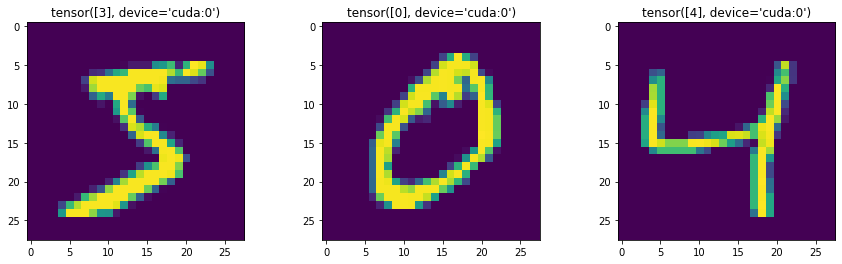

In [18]:
# Show first few sample inputs and predictions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
for i in range(3):
    ax = [ax1, ax2, ax3][i]
    ax.imshow(example_data[i][0])
    ax.set_title(f"{model(example_data[i].to(device)).argmax(1)}")
plt.show()